# FSC

In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
from matplotlib.colors import ListedColormap

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"

band3_file = sentinel_path + "T35WMQ_20230515T095559_B03_20m.jp2"   # Green
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"   # Red
band5_file = sentinel_path + "T35WMQ_20230515T095559_B05_20m.jp2"  # NIR
band6_file = sentinel_path + "T35WMQ_20230515T095559_B06_20m.jp2"  # NIR
band7_file = sentinel_path + "T35WMQ_20230515T095559_B07_20m.jp2"  # NIR
band8_file = sentinel_path + "T35WMQ_20230515T095559_B08_20m.jp2"  # NIR
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"  # NIR
band11_file = sentinel_path + "T35WMQ_20230515T095559_B11_20m.jp2"  # SWIR
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"  # SWIR

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

band3, transform_band3, crs_band3, src_band3 = load_raster(band3_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)
band5, transform_band5, crs_band5, src_band5 = load_raster(band5_file)
band6, transform_band6, crs_band6, src_band6 = load_raster(band6_file)
band7, transform_band7, crs_band7, src_band7 = load_raster(band7_file)
band8, transform_band8, crs_band8, src_band8 = load_raster(band8_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band11, transform_band11, crs_band11, src_band11 = load_raster(band11_file)
band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

# Create SWIR composite and mask (if needed)
swir_composite = create_swir_composite(band12, band8a, band4)

def create_mask(swir_composite):
    """
    Generates a mask where active areas are marked and inactive areas are set to NaN.
    """
    # Thresholds based on the description of the features
    water_marsh_mask = ((swir_composite[:, :, 0] < 1200))  # Dark in SWIR (water/marsh)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    #print(combined_mask)
    
    # Set mask to NaN where it's not active, and 1 where it is active
    combined_mask = np.where(combined_mask, 1, np.nan)
    
    return combined_mask
    
mask = create_mask(swir_composite)  # Mask generation (can be omitted if not needed)

def calculate_ndfsi(green_band, swir_band):
    """
    Calculate the NDFSI using Green (Band 3) and SWIR (Band 12).
    """
    ndfsi = (green_band - swir_band) / (green_band + swir_band)
    return ndfsi

ndfsi = calculate_ndfsi(band3, band11)

def apply_mask(ndfsi, mask):
    """
    Apply the mask to the NDFSI array. Masked areas will be set to NaN.
    """
    # Set NDFSI values where the mask is NaN to the NDFSI value, and everything else to NaN
    masked_ndfsi = np.where(np.isnan(mask), ndfsi, np.nan)
    return masked_ndfsi

masked_ndfsi = apply_mask(ndfsi, mask)

def apply_snow_threshold(ndfsi, threshold):
    """
    Apply a snow threshold to the NDFSI. 
    Below the threshold, set values to 1 (snow), and above it, set to 0 (no snow).
    """
    snow_mask = np.where(ndfsi <= threshold, 1, 0)
    return snow_mask

# Apply the threshold to create a binary snow mask
threshold = 0.4
snow_mask = apply_snow_threshold(masked_ndfsi, threshold)

def average_snow_cover_with_resize(snow_mask, transform, block_size_meters=1000):
    """
    Calculate the fractional snow cover in 1 km x 1 km blocks and resize the array to match the new resolution.
    Also, update the transform to match the resized array.
    """
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    # Calculate the number of pixels that correspond to the block size (1 km x 1 km)
    block_size_x = int(block_size_meters / pixel_size_x)
    block_size_y = int(block_size_meters / pixel_size_y)
    
    # Get the dimensions of the snow mask
    rows, cols = snow_mask.shape
    
    # Calculate the dimensions of the new array
    new_rows = rows // block_size_y
    new_cols = cols // block_size_x
    
    # Initialize an array for the averaged snow cover with the new dimensions
    resized_snow_cover = np.full((new_rows, new_cols), np.nan, dtype=float)
    
    # Iterate over the new dimensions
    for i in range(new_rows):
        for j in range(new_cols):
            # Extract the block from the original array
            block = snow_mask[i*block_size_y:(i+1)*block_size_y, j*block_size_x:(j+1)*block_size_x]
            
            # Calculate the mean of the block, ignoring NaNs
            if np.isnan(block).all():
                block_mean = np.nan
            else:
                block_mean = np.nanmean(block)
            
            # Assign the mean value to the resized array
            resized_snow_cover[i, j] = block_mean
    
    # Calculate the new transform for the resized array
    new_transform = rasterio.Affine(
        transform[0] * block_size_x, 0, transform[2],
        0, transform[4] * block_size_y, transform[5]
    )

    return resized_snow_cover, new_transform

averaged_snow_cover, new_transform = average_snow_cover_with_resize(snow_mask, transform_band3)

snow_left, snow_bottom = new_transform * (0, averaged_snow_cover.shape[0])
snow_right, snow_top = new_transform * (averaged_snow_cover.shape[1], 0)

plt.figure(figsize=(10, 10))
plt.imshow(averaged_snow_cover, cmap='gray', extent=(snow_left, snow_right, snow_bottom, snow_top), aspect='auto')
plt.colorbar(label='Snow Cover Fraction')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Snow Cover (1 km x 1 km) in Sentinel-2 CRS')
plt.show()

RasterioIOError: ../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/T35WMQ_20230515T095559_B03_20m.jp2: No such file or directory

# DEM

Searching for .tif files in the directory...
Total .tif files found: 324
DEM merging completed.


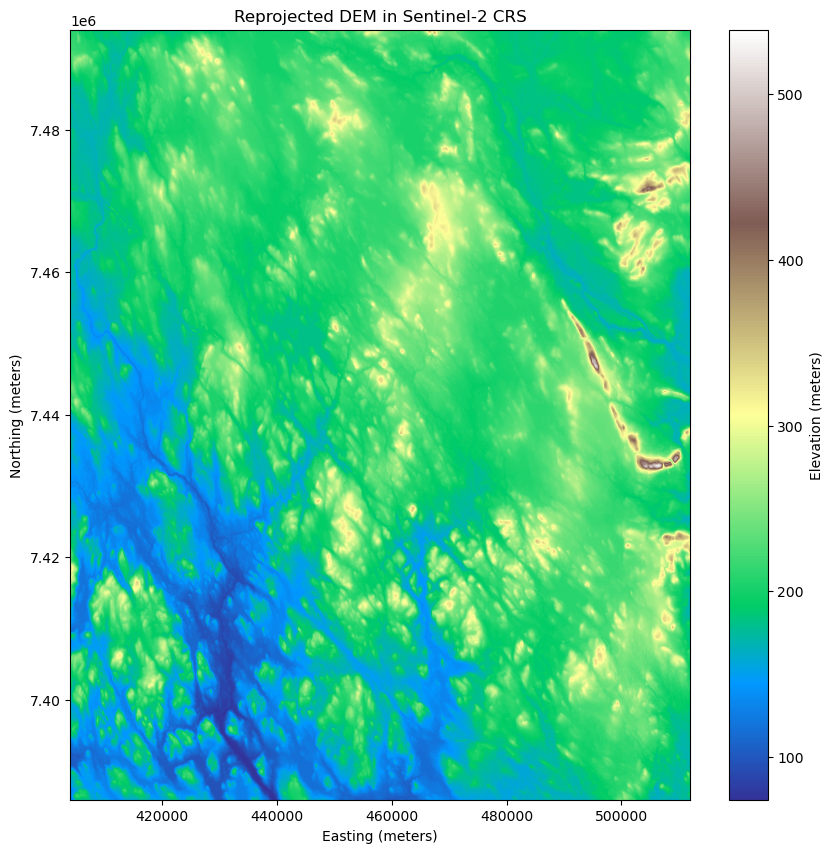

In [28]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject
import matplotlib.pyplot as plt
from pyproj import Transformer

# Define the base directory containing DEM files
base_directory = '../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/'

def find_all_tif_files(base_dir):
    """
    Find all .tif files recursively in the given directory.
    """
    print("Searching for .tif files in the directory...")
    tif_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tif'):
                full_path = os.path.join(root, file)
                tif_files.append(full_path)
                # print(f"Found: {full_path}")
    print(f"Total .tif files found: {len(tif_files)}")
    return tif_files

# Find all .tif files in the directory
dem_files = find_all_tif_files(base_directory)

def resample_and_merge_dems(dem_files):
    """
    Resample all DEM files to 10m resolution and merge them using rasterio's merge function.
    """
    datasets = []
    dem_crs = None

    for i, dem_file in enumerate(dem_files):
        # print(f"Processing file {i+1}/{len(dem_files)}: {dem_file}")
        with rasterio.open(dem_file) as src:
            if dem_crs == None:
                dem_crs = src.crs
            try:
                #resampled_data, resampled_transform, resampled_crs = resampled_data, src.transform*src.transform.scale(5,5), src.crs
                resampled_data = src.read(1, out_shape=(src.width//5, src.height//5), resampling=Resampling.average)

                memfile = MemoryFile()
                mem_dataset = memfile.open(
                    driver='GTiff',
                    height=resampled_data.shape[0],
                    width=resampled_data.shape[1],
                    count=1,
                    dtype=resampled_data.dtype,
                    crs=src.crs,
                    transform=src.transform*src.transform.scale(5,5)
                )
                mem_dataset.write(resampled_data, 1)
                # mem_dataset = create_memory_dataset(resampled_data, resampled_transform, resampled_crs)
                
                datasets.append(mem_dataset)
                # print(f"File {i+1} resampled and stored in memory.")
            except Exception as e:
                print(f"Error processing {dem_file}: {e}")

    # Merge the in-memory datasets
    try:
        mosaic, out_trans = merge(datasets)
        print("DEM merging completed.")
    except Exception as e:
        print(f"Error during merging: {e}")
        return None, None, None

    # Close all in-memory files
    for dataset in datasets:
        dataset.close()

    return mosaic, out_trans, dem_crs

merged_dem, merged_transform, dem_crs = resample_and_merge_dems(dem_files)

def reproject_dem_to_crs(src_array, src_transform, src_crs, dst_crs):
    """
    Reproject the DEM array to the target CRS (Sentinel-2 CRS).
    """
    width, height = src_array.shape[2], src_array.shape[1]

    # Calculate the bounding box from the source transform
    left, top = src_transform * (0, 0)
    right, bottom = src_transform * (width, height)
    
    # Calculate the transform and shape of the output array
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, left, bottom, right, top)

    # Prepare the destination array
    dst_array = np.empty((dst_height, dst_width), dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array[0],
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    return dst_array, dst_transform

# Reproject the merged DEM to match the Sentinel-2 CRS (crs_band3)
reprojected_dem, reprojected_transform = reproject_dem_to_crs(merged_dem, merged_transform, dem_crs, crs_band3)

dem_left, dem_bottom = reprojected_transform * (0, reprojected_dem.shape[0])
dem_right, dem_top = reprojected_transform * (reprojected_dem.shape[1], 0)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(reprojected_dem, cmap='terrain', extent=(dem_left, dem_right, dem_bottom, dem_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Combination

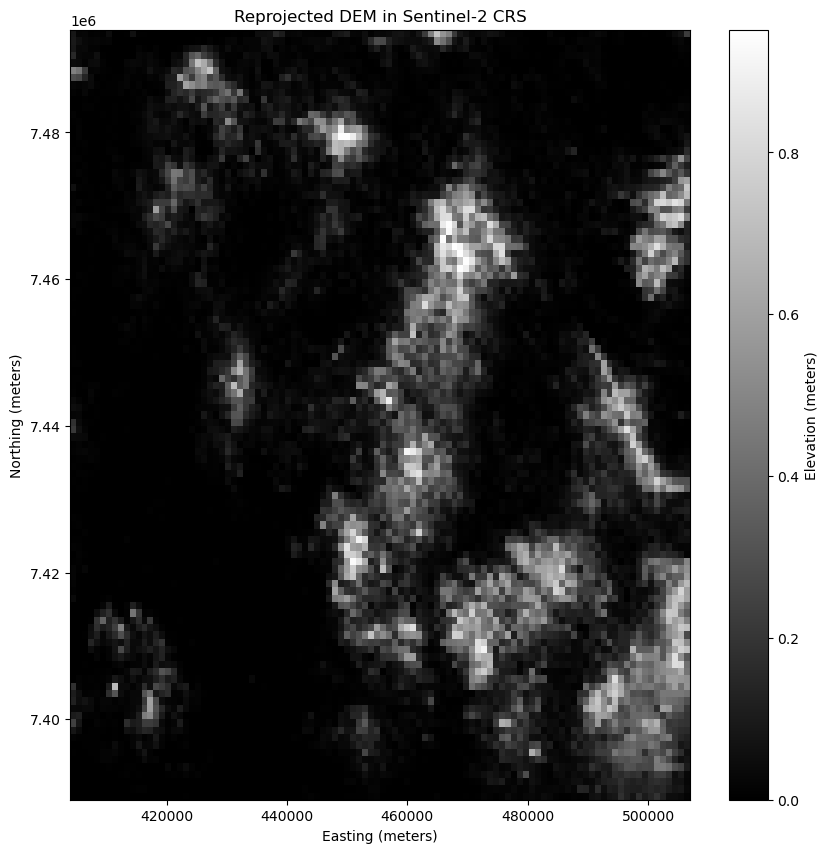

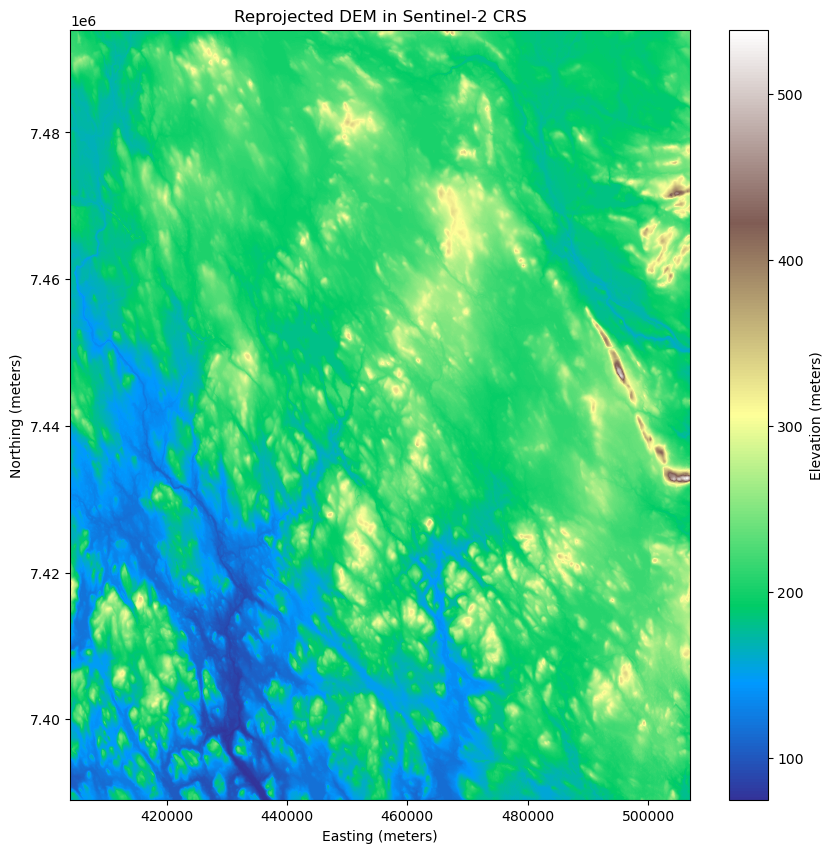

In [29]:
import numpy as np
import rasterio

def crop_to_overlap(array1, transform1, array2, transform2):
    """
    Crops two arrays to their overlapping area and returns the cropped arrays along with their updated transforms.

    Parameters:
    array1 (np.ndarray): The first array to crop.
    transform1 (Affine): The affine transformation of the first array.
    array2 (np.ndarray): The second array to crop.
    transform2 (Affine): The affine transformation of the second array.

    Returns:
    tuple: Cropped arrays and their corresponding updated transforms.
           (cropped_array1, new_transform1, cropped_array2, new_transform2)
    """
    # Get the bounding coordinates of both arrays
    left1, bottom1 = transform1 * (0, array1.shape[0])
    right1, top1 = transform1 * (array1.shape[1], 0)
    
    left2, bottom2 = transform2 * (0, array2.shape[0])
    right2, top2 = transform2 * (array2.shape[1], 0)

    # Calculate the overlapping bounds
    overlap_left = max(left1, left2)
    overlap_right = min(right1, right2)
    overlap_top = min(top1, top2)
    overlap_bottom = max(bottom1, bottom2)

    # If there's no overlap, return None
    if overlap_left >= overlap_right or overlap_bottom >= overlap_top:
        raise ValueError("The two arrays do not overlap.")

    # Calculate the new row and column indices for array1
    row_start1, col_start1 = ~transform1 * (overlap_left, overlap_top)
    row_end1, col_end1 = ~transform1 * (overlap_right, overlap_bottom)

    # Ensure indices are integers within the array bounds
    row_start1 = max(0, int(np.floor(row_start1)))
    col_start1 = max(0, int(np.floor(col_start1)))
    row_end1 = min(array1.shape[0], int(np.ceil(row_end1)))
    col_end1 = min(array1.shape[1], int(np.ceil(col_end1)))

    # Crop array1
    cropped_array1 = array1[row_start1:row_end1, col_start1:col_end1]

    # Update the transform for the cropped array1
    new_transform1 = transform1 * rasterio.Affine.translation(col_start1, row_start1)

    # Calculate the new row and column indices for array2
    row_start2, col_start2 = ~transform2 * (overlap_left, overlap_top)
    row_end2, col_end2 = ~transform2 * (overlap_right, overlap_bottom)

    # Ensure indices are integers within the array bounds
    row_start2 = max(0, int(np.floor(row_start2)))
    col_start2 = max(0, int(np.floor(col_start2)))
    row_end2 = min(array2.shape[0], int(np.ceil(row_end2)))
    col_end2 = min(array2.shape[1], int(np.ceil(col_end2)))

    # Crop array2
    cropped_array2 = array2[row_start2:row_end2, col_start2:col_end2]

    # Update the transform for the cropped array2
    new_transform2 = transform2 * rasterio.Affine.translation(col_start2, row_start2)

    return cropped_array1, new_transform1, cropped_array2, new_transform2


dem_cropped, dem_transform_cropped, snow_cropped, snow_transform_cropped = crop_to_overlap(
                                                                                reprojected_dem,
                                                                                reprojected_transform,
                                                                                averaged_snow_cover,
                                                                                new_transform)

c_left, c_bottom = reprojected_transform * (0, dem_cropped.shape[0])
c_right, c_top = reprojected_transform * (dem_cropped.shape[1], 0)

# Plot the Snow Cover
plt.figure(figsize=(10, 10))
plt.imshow(snow_cropped, cmap='gray', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(dem_cropped, cmap='terrain', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

# Topography

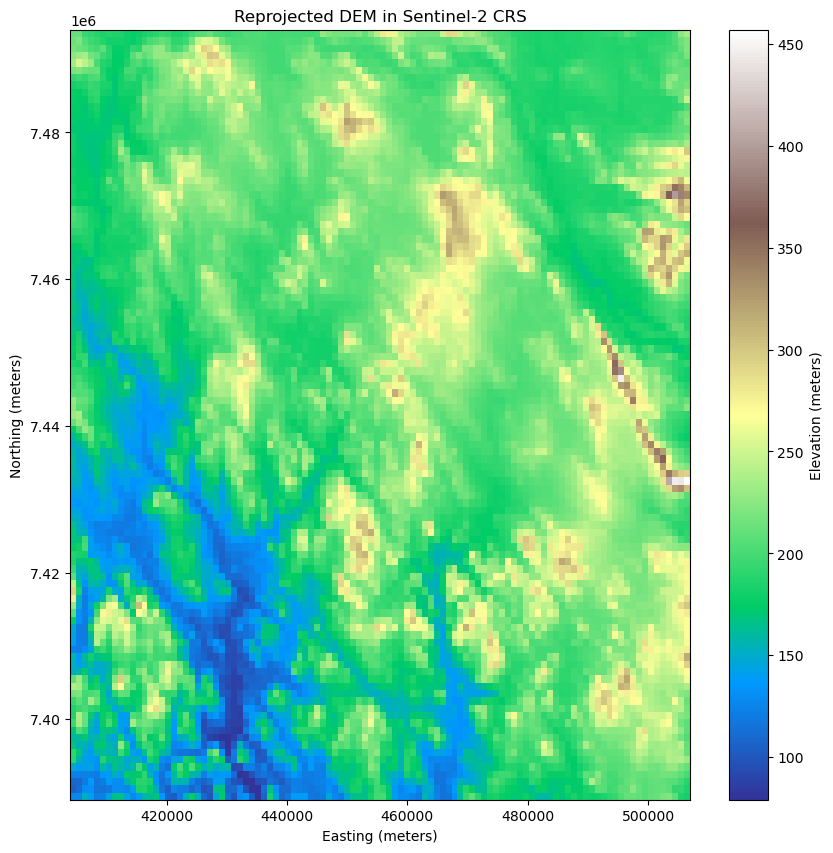

In [30]:
def averaged_to_snow_resolution(array, snow_shape):
    """
    Averages the input array down to match the shape of the snow cover array.

    Parameters:
    array (np.ndarray): The input array to be downsampled.
    snow_shape (tuple): The target shape of the snow cover array (height, width).

    Returns:
    np.ndarray: The resampled array with the same shape as the snow cover array.
    """
    # Get the shape of the input array
    array_height, array_width = array.shape
    
    # Get the target snow grid shape
    snow_height, snow_width = snow_shape
    
    # Calculate the bin size for averaging
    bin_size_y = array_height // snow_height
    bin_size_x = array_width // snow_width
    
    # Reshape and average the input array to match the snow cover shape
    resampled_array = array[:bin_size_y * snow_height, :bin_size_x * snow_width]
    resampled_array = resampled_array.reshape(snow_height, bin_size_y, snow_width, bin_size_x).mean(axis=(1, 3))
    
    return resampled_array

dem_cropped_resampled = averaged_to_snow_resolution(dem_cropped, snow_cropped.shape)
                                              #crs_band3, crs_band3)
# print(dem_cropped_resampled.shape)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(dem_cropped_resampled, cmap='terrain', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Reprojected DEM in Sentinel-2 CRS')
plt.show()

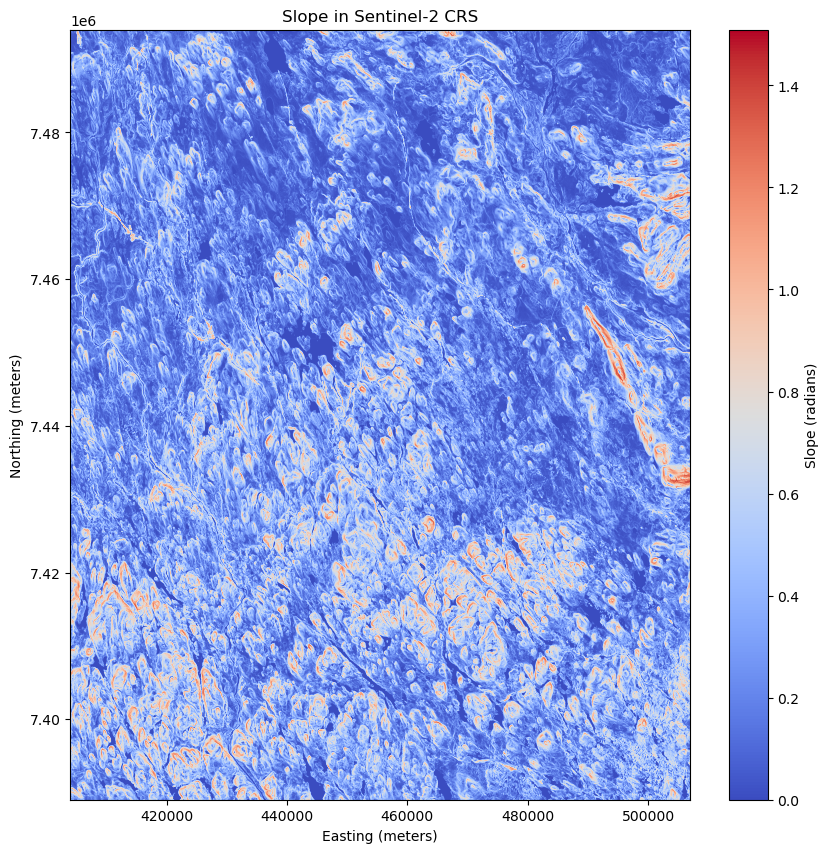

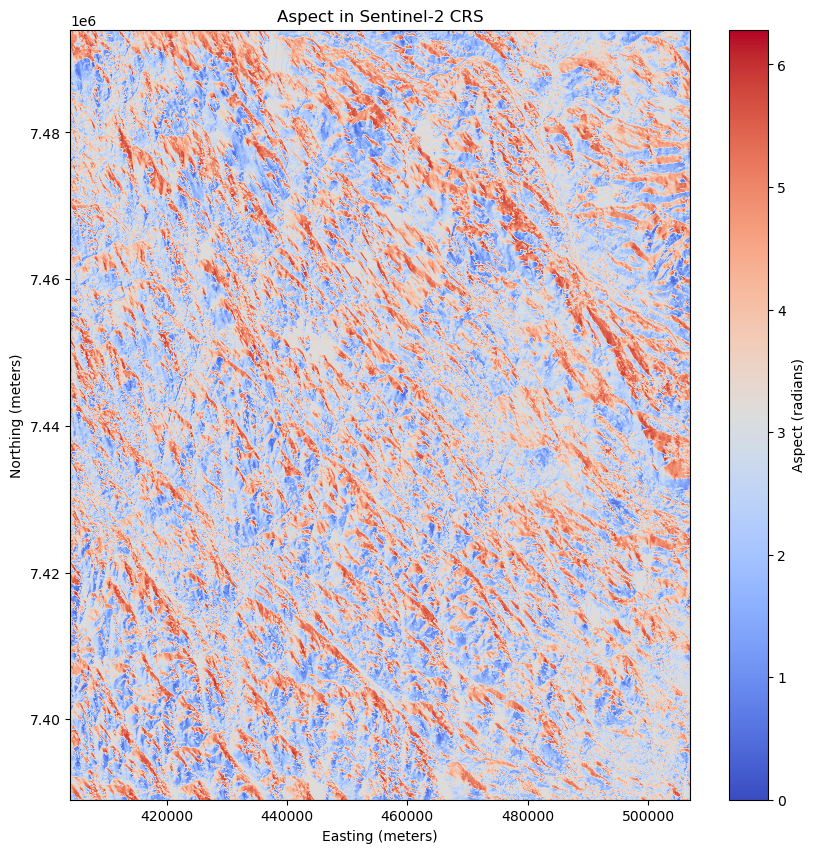

In [36]:
def compute_aspect_slope(dem_cropped):
    """
    Computes the aspect and slope of each pixel in the DEM.

    Parameters:
    dem_cropped (np.ndarray): The cropped DEM array.

    Returns:
    tuple: Two arrays of the same shape as dem_cropped: (aspect, slope).
           - aspect: The aspect in degrees (0 to 360).
           - slope: The slope in degrees.
    """
    # Calculate the gradients (difference in elevation) in x and y directions
    dz_dx = np.gradient(dem_cropped, axis=1)  # Gradient along x-axis (columns)
    dz_dy = np.gradient(dem_cropped, axis=0)  # Gradient along y-axis (rows)

    # Calculate the slope in radians
    slope_radians = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))

    # Calculate the aspect in radians
    aspect_radians = np.arctan2(-dz_dy, -dz_dx)
    aspect_radians = np.where(aspect_radians < 0, 2 * np.pi + aspect_radians, aspect_radians)

    return slope_radians, aspect_radians

slope, aspect = compute_aspect_slope(dem_cropped)

aspect_resampled = averaged_to_snow_resolution(aspect, snow_cropped.shape)
slope_resampled = averaged_to_snow_resolution(slope, snow_cropped.shape)

# Plot the slope
plt.figure(figsize=(10, 10))
plt.imshow(slope, cmap='coolwarm', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Slope (radians)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Slope in Sentinel-2 CRS')
plt.show()

# Plot the aspect
plt.figure(figsize=(10, 10))
plt.imshow(aspect, cmap='coolwarm', extent=(c_left, c_right, c_bottom, c_top), aspect='auto')
plt.colorbar(label='Aspect (radians)')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Aspect in Sentinel-2 CRS')
plt.show()

<xarray.Dataset> Size: 220kB
Dimensions:  (y: 105, x: 104)
Coordinates:
  * y        (y) float64 840B 7.496e+06 7.495e+06 ... 7.393e+06 7.392e+06
  * x        (x) float64 832B 4.05e+05 4.06e+05 4.07e+05 ... 5.07e+05 5.08e+05
Data variables:
    snow     (y, x) float64 87kB 0.086 0.0212 0.0224 ... 0.0512 0.0388 0.016
    dem      (y, x) float32 44kB 211.5 211.4 194.9 192.4 ... 207.9 185.5 181.6
    slope    (y, x) float32 44kB 0.0921 0.4967 0.1301 ... 0.5668 0.3087 0.2183
    aspect   (y, x) float32 44kB 4.233 4.33 4.574 3.849 ... 4.33 2.962 3.01


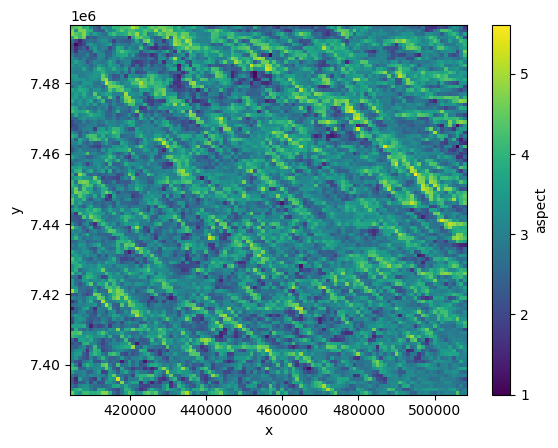

In [55]:
import xarray as xr
import numpy as np

def create_combined_xarray(snow, dem, slope, aspect, snow_transform):
    """
    Combines snow, dem, slope, and aspect arrays into a single xarray Dataset with four layers and coordinates.

    Parameters:
    snow (np.ndarray): Snow cover array (2D).
    dem (np.ndarray): Resampled DEM array (2D).
    slope (np.ndarray): Resampled slope array (2D).
    aspect (np.ndarray): Resampled aspect array (2D).
    snow_transform (Affine): The affine transformation of the snow cover array.

    Returns:
    xr.Dataset: An xarray Dataset with four layers: 'snow', 'dem', 'slope', and 'aspect', with coordinates.
    """
    # Ensure all arrays have the same shape
    assert snow.shape == dem.shape == slope.shape == aspect.shape, "All arrays must have the same shape."

    # Get the dimensions of the arrays
    height, width = snow.shape

    # Generate coordinates based on the snow_transform
    x_coords = snow_transform.c + np.arange(width) * snow_transform.a
    y_coords = snow_transform.f + np.arange(height) * snow_transform.e

    # Create a DataArray for each variable
    snow_da = xr.DataArray(snow, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="snow")
    dem_da = xr.DataArray(dem, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="dem")
    slope_da = xr.DataArray(slope, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="slope")
    aspect_da = xr.DataArray(aspect, dims=["y", "x"], coords={"y": y_coords, "x": x_coords}, name="aspect")

    # Combine into a single Dataset
    dataset = xr.Dataset({"snow": snow_da, "dem": dem_da, "slope": slope_da, "aspect": aspect_da})

    return dataset

# Example usage
combined_dataset = create_combined_xarray(snow_cropped, dem_cropped_resampled, slope_resampled, aspect_resampled, snow_transform_cropped)

# Display the combined xarray dataset
print(combined_dataset)

combined_dataset.aspect.plot()

# combined_dataset.to_netcdf('sodankyla_topography.nc')

# Load NetCDF Topography from here

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sodankyla_topography = xr.load_dataset('sodankyla_topography.nc')
# print(sodankyla_topography.slope.values.min(), sodankyla_topography.slope.values.max())
# print(sodankyla_topography.aspect.values.min(), sodankyla_topography.aspect.values.max())
# plt.figure(figsize=(10,10))
# sodankyla_topography.aspect.plot()
sodankyla_topography
# plt.figure(figsize=(10,10))
# sodankyla_topography.dem.plot()
# plt.figure(figsize=(10,10))
# plt.scatter(sodankyla_topography.slope.values.flatten(), sodankyla_topography.snow.values.flatten())

# plt.figure(figsize=(10,10))
# plt.scatter(sodankyla_topography.aspect.values.flatten(), sodankyla_topography.snow.values.flatten())

<xarray.Dataset> Size: 220kB
Dimensions:  (y: 105, x: 104)
Coordinates:
  * y        (y) float64 840B 7.496e+06 7.495e+06 ... 7.393e+06 7.392e+06
  * x        (x) float64 832B 4.05e+05 4.06e+05 4.07e+05 ... 5.07e+05 5.08e+05
Data variables:
    snow     (y, x) float64 87kB 0.086 0.0212 0.0224 ... 0.0512 0.0388 0.016
    dem      (y, x) float32 44kB 211.5 211.4 194.9 192.4 ... 207.9 185.5 181.6
    slope    (y, x) float32 44kB 0.0921 0.4967 0.1301 ... 0.5668 0.3087 0.2183
    aspect   (y, x) float32 44kB 4.233 4.33 4.574 3.849 ... 4.33 2.962 3.01

# Comparative Model

In [41]:
import numpy as np
import xarray as xr
from scipy.optimize import minimize
from sklearn.metrics import root_mean_squared_error

def calibrate_model(dataset, distance_threshold=5000, sample_size=1000, max_neighbors=50):
    """
    Calibrates the coefficients a, b, c, and d based on a subsampled training area of the dataset.

    Parameters:
    dataset (xr.Dataset): The xarray dataset containing 'snow', 'dem', 'slope', and 'aspect'.
    distance_threshold (float): The distance threshold within which to consider neighboring pixels (in meters).
    sample_size (int): The number of training pixels to sample for calibration.
    max_neighbors (int): The maximum number of neighboring pixels to consider for each training pixel.

    Returns:
    tuple: The calibrated coefficients (a, b, c, d).
    """
    # Extract the variables from the dataset
    snow = dataset['snow'].values
    dem = dataset['dem'].values
    slope = dataset['slope'].values
    aspect = dataset['aspect'].values
    x_coords = dataset['x'].values
    y_coords = dataset['y'].values
    
    # Dimensions
    height, width = snow.shape

    # Create a mask for the test area (top-left quarter)
    test_mask = np.zeros_like(snow, dtype=bool)
    test_mask[:height // 2, :width // 2] = True

    # Indices for training area
    train_indices = np.argwhere(~test_mask)

    # Subsample the training indices
    if len(train_indices) > sample_size:
        np.random.seed(42)
        sampled_indices = train_indices[np.random.choice(len(train_indices), sample_size, replace=False)]
    else:
        sampled_indices = train_indices

    print(f"Using {len(sampled_indices)} pixels for training.")

    # Define the function to minimize (RMSE)
    def objective(params):
        a, b, c, d, e = params
        predictions = []
        targets = []

        for idx_count, idx in enumerate(sampled_indices):
            i, j = idx
            snow_A = snow[i, j]
            dem_A = dem[i, j]
            slope_A = slope[i, j]
            aspect_A = aspect[i, j]

            # Find neighboring pixels within the distance threshold
            neighbors = [
                (ii, jj) for ii in range(height) for jj in range(width)
                if not test_mask[ii, jj] and ((x_coords[jj] - x_coords[j])**2 + (y_coords[ii] - y_coords[i])**2) <= distance_threshold**2
            ]

            # Limit the number of neighbors
            if len(neighbors) > max_neighbors:
                neighbors = neighbors[:max_neighbors]

            for ii, jj in neighbors:
                snow_B = snow[ii, jj]
                dem_B = dem[ii, jj]
                slope_B = slope[ii, jj]
                aspect_B = aspect[ii, jj]

                # Calculate predicted snow_B using the new formula and cap it between 0 and 1
                predicted_snow_B = (snow_A +
                                    a * (dem_B - dem_A) +
                                    b * (np.cos(slope_B + d) - np.cos(slope_A + d)) +
                                    #c * (np.exp(d * np.sin(aspect_B)) - np.exp(d * np.sin(aspect_A))))
                                    c * (np.cos(aspect_B + e) - np.cos(aspect_A + e)))

                predicted_snow_B = np.clip(predicted_snow_B, 0, 1)

                # Collect the prediction and the actual value
                predictions.append(predicted_snow_B)
                targets.append(snow[ii, jj])
        
        rmse = root_mean_squared_error(targets, predictions)
        print(f"Current RMSE: {rmse}")
        return rmse

    # Initial guess for coefficients
    initial_guess = [0.1, 0.1, 0.1, 0, np.pi]

    # Set bounds for the parameters: a >= 0, b >= 0, c >= 0, d > 0
    bounds = [(0, None), (0, None), (0, None), (-np.pi,np.pi), (0,2*np.pi)]

    print("Starting optimization...")
    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds, options={'maxiter': 50, 'disp': True})
    print("Optimization complete.")

    # Calibrated coefficients
    a, b, c, d, e = result.x
    print(f"Calibrated coefficients: a={a}, b={b}, c={c}, d={d}, e={e}")
    return a, b, c, d, e
    
# Calibrate the model
a, b, c, d, e = calibrate_model(sodankyla_topography)

Using 1000 pixels for training.
Starting optimization...
Current RMSE: 0.5653246214196458
Current RMSE: 0.565324629166097
Current RMSE: 0.5653246214118766
Current RMSE: 0.5653246213814263
Current RMSE: 0.5653246214166889
Current RMSE: 0.5653246214236838
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65325D-01    |proj g|=  1.00000D-01
Current RMSE: 0.1532412223581389
Current RMSE: 0.1532411437471105
Current RMSE: 0.1532412224878144
Current RMSE: 0.1532412226989914
Current RMSE: 0.15324122238585308
Current RMSE: 0.1532412223240348
Current RMSE: 0.5577407266401031
Current RMSE: 0.5577407358483291
Current RMSE: 0.5577407266305072
Current RMSE: 0.557740726598643
Current RMSE: 0.5577407266366233
Current RMSE: 0.5577407266439839
Current RMSE: 0.48259202523398315
Current RMSE: 0.4825920553716669
Current RMSE: 0.4825920251939968
Current RMSE: 0.48259

Calculating RMSE for training area...
Processed 0 out of 8216 pixels in training area...
Processed 100 out of 8216 pixels in training area...
Processed 200 out of 8216 pixels in training area...
Processed 300 out of 8216 pixels in training area...
Processed 400 out of 8216 pixels in training area...
Processed 500 out of 8216 pixels in training area...
Processed 600 out of 8216 pixels in training area...
Processed 700 out of 8216 pixels in training area...
Processed 800 out of 8216 pixels in training area...
Processed 900 out of 8216 pixels in training area...
Processed 1000 out of 8216 pixels in training area...
Processed 1100 out of 8216 pixels in training area...
Processed 1200 out of 8216 pixels in training area...
Processed 1300 out of 8216 pixels in training area...
Processed 1400 out of 8216 pixels in training area...
Processed 1500 out of 8216 pixels in training area...
Processed 1600 out of 8216 pixels in training area...
Processed 1700 out of 8216 pixels in training area...
Pr

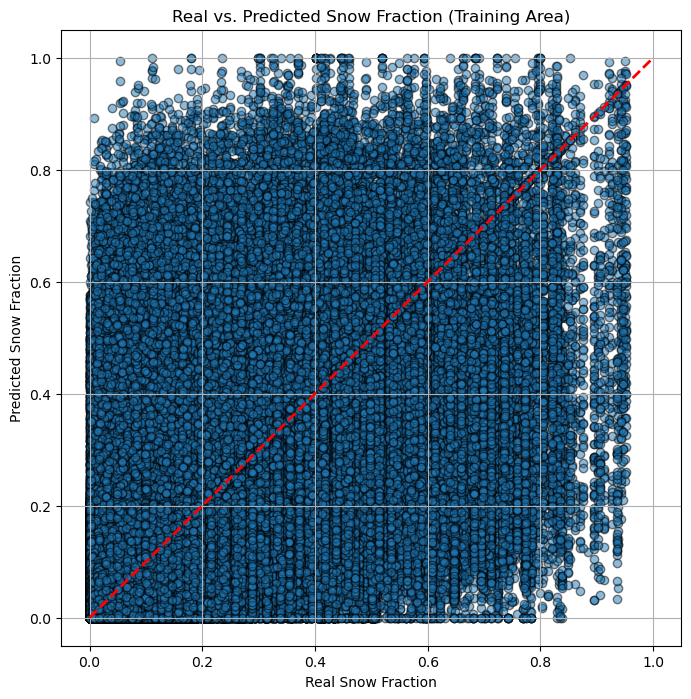

Calculating RMSE for test area...
Processed 0 out of 2704 pixels in test area...
Processed 100 out of 2704 pixels in test area...
Processed 200 out of 2704 pixels in test area...
Processed 300 out of 2704 pixels in test area...
Processed 400 out of 2704 pixels in test area...
Processed 500 out of 2704 pixels in test area...
Processed 600 out of 2704 pixels in test area...
Processed 700 out of 2704 pixels in test area...
Processed 800 out of 2704 pixels in test area...
Processed 900 out of 2704 pixels in test area...
Processed 1000 out of 2704 pixels in test area...
Processed 1100 out of 2704 pixels in test area...
Processed 1200 out of 2704 pixels in test area...
Processed 1300 out of 2704 pixels in test area...
Processed 1400 out of 2704 pixels in test area...
Processed 1500 out of 2704 pixels in test area...
Processed 1600 out of 2704 pixels in test area...
Processed 1700 out of 2704 pixels in test area...
Processed 1800 out of 2704 pixels in test area...
Processed 1900 out of 2704 p

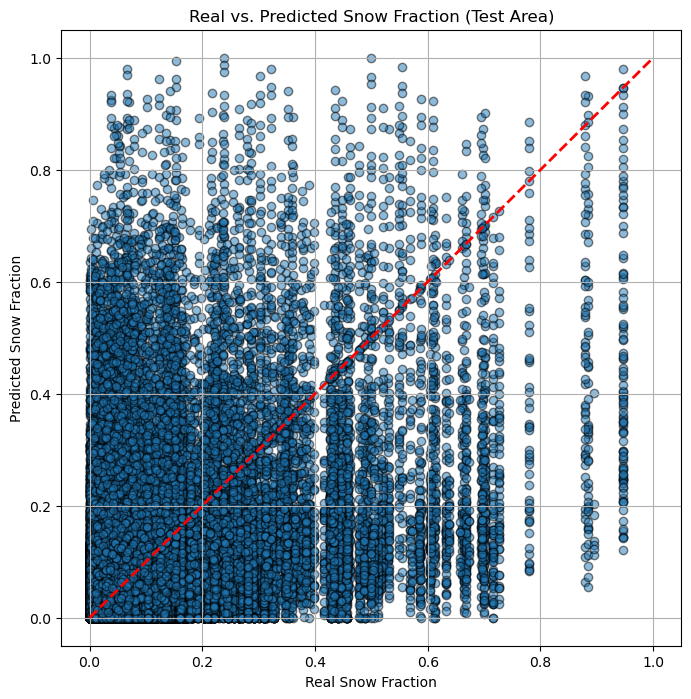

Training RMSE: 0.1409221357265242
Test RMSE: 0.10420708425940116


In [5]:
import numpy as np
import xarray as xr
from scipy.optimize import minimize
from sklearn.metrics import root_mean_squared_error

def evaluate_model(dataset, a, b, c, d, e, distance_threshold=5000, max_neighbors=50):
    """
    Evaluates the calibrated model in both the training and test areas.

    Parameters:
    dataset (xr.Dataset): The xarray dataset containing 'snow', 'dem', 'slope', and 'aspect'.
    a, b, c, d, e (float): Calibrated coefficients.
    distance_threshold (float): The distance threshold within which to consider neighboring pixels (in meters).
    max_neighbors (int): The maximum number of neighboring pixels to consider for each pixel.

    Returns:
    tuple: RMSE for the training area and RMSE for the test area.
    """
    # Extract the variables from the dataset
    snow = dataset['snow'].values
    dem = dataset['dem'].values
    slope = dataset['slope'].values
    aspect = dataset['aspect'].values
    x_coords = dataset['x'].values
    y_coords = dataset['y'].values
    
    # Dimensions
    height, width = snow.shape

    # Create a mask for the test area (top-left quarter)
    test_mask = np.zeros_like(snow, dtype=bool)
    test_mask[:height // 2, :width // 2] = True

    # Separate training and test indices
    train_indices = np.argwhere(~test_mask)
    test_indices = np.argwhere(test_mask)

    def calculate_rmse(indices, label):
        predictions = []
        targets = []

        print(f"Calculating RMSE for {label} area...")

        for idx_count, idx in enumerate(indices):
            i, j = idx
            snow_A = snow[i, j]
            dem_A = dem[i, j]
            slope_A = slope[i, j]
            aspect_A = aspect[i, j]

            # Find neighboring pixels within the distance threshold
            neighbors = [
                (ii, jj) for ii in range(height) for jj in range(width)
                if ((x_coords[jj] - x_coords[j])**2 + (y_coords[ii] - y_coords[i])**2) <= distance_threshold**2
            ]

            # Limit the number of neighbors
            if len(neighbors) > max_neighbors:
                neighbors = neighbors[:max_neighbors]

            if idx_count % 100 == 0:
                print(f"Processed {idx_count} out of {len(indices)} pixels in {label} area...")

            for ii, jj in neighbors:
                snow_B = snow[ii, jj]
                dem_B = dem[ii, jj]
                slope_B = slope[ii, jj]
                aspect_B = aspect[ii, jj]

                # Calculate predicted snow_B using the new formula and cap it between 0 and 1
                predicted_snow_B = (snow_A +
                                    a * (dem_B - dem_A) +
                                    b * (np.cos(slope_B + d) - np.cos(slope_A + d)) +
                                    c * (np.cos(aspect_B + e) - np.cos(aspect_A + e)))

                predicted_snow_B = np.clip(predicted_snow_B, 0, 1)

                predictions.append(predicted_snow_B)
                targets.append(snow[ii, jj])
        
        rmse = root_mean_squared_error(targets, predictions)
        print(f"Finished calculating RMSE for {label} area. RMSE: {rmse}")

        # Create a scatter plot of real vs. predicted values
        plt.figure(figsize=(8, 8))
        plt.scatter(targets, predictions, alpha=0.5, edgecolors='k', marker='o')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
        plt.xlabel('Real Snow Fraction')
        plt.ylabel('Predicted Snow Fraction')
        plt.title(f'Real vs. Predicted Snow Fraction ({label.capitalize()} Area)')
        plt.grid(True)
        plt.show()
        return rmse

    # RMSE for the training area
    rmse_train = calculate_rmse(train_indices, "training")

    # RMSE for the test area
    rmse_test = calculate_rmse(test_indices, "test")

    return rmse_train, rmse_test

# Evaluate the model
rmse_train, rmse_test = evaluate_model(sodankyla_topography, a, b, c, d, e)

# Display the results
print(f"Training RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")

# ML Approach

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

def find_nearest_reference(pixel_coords, reference_coords):
    distances = [((pixel_coords[0] - ref[0])**2 + (pixel_coords[1] - ref[1])**2) for ref in reference_coords]
    nearest_index = np.argmin(distances)
    return reference_coords[nearest_index]

def stratified_spatial_snow_selection(dataset, num_bins=10, num_samples_per_bin=10):
    """
    Selects reference pixels stratified by fixed snow cover ranges and maximized spatial separation.
    
    Parameters:
    dataset (xr.Dataset): The xarray dataset containing 'snow', 'y', and 'x' values.
    num_bins (int): Number of fixed snow bins (default: 10, ranges 0.0-1.0 by 0.1).
    num_samples_per_bin (int): Number of spatially separated samples to pick from each bin.
    
    Returns:
    list of tuples: List of selected reference pixels in coordinate form (y, x).
    """
    # Convert dataset to DataFrame
    df = dataset[['snow', 'y', 'x']].to_dataframe().reset_index()
    df = df.dropna(subset=['snow'])

    # Define fixed snow cover bins
    snow_bin_edges = np.linspace(0, 1, num_bins + 1)  # e.g., [0.0, 0.1, 0.2, ..., 1.0]
    selected_references = []

    # Stratified sampling with fixed bins
    for i in range(num_bins):
        # Define the bin range
        lower_bound, upper_bound = snow_bin_edges[i], snow_bin_edges[i + 1]
        bin_df = df[(df['snow'] >= lower_bound) & (df['snow'] < upper_bound)].copy()  # Use .copy() here
        
        # If not enough pixels in the current bin, look in the nearest bin
        if len(bin_df) < num_samples_per_bin:
            # Search in adjacent bins
            extra_needed = num_samples_per_bin - len(bin_df)
            lower_bin, upper_bin = i - 1, i + 1
            
            while extra_needed > 0 and (lower_bin >= 0 or upper_bin < num_bins):
                # Add pixels from the lower adjacent bin if available
                if lower_bin >= 0:
                    lower_bound, _ = snow_bin_edges[lower_bin], snow_bin_edges[lower_bin + 1]
                    lower_df = df[(df['snow'] >= lower_bound) & (df['snow'] < snow_bin_edges[lower_bin + 1])]
                    bin_df = pd.concat([bin_df, lower_df]).drop_duplicates()
                    extra_needed = num_samples_per_bin - len(bin_df)
                    lower_bin -= 1

                # Add pixels from the upper adjacent bin if available
                if extra_needed > 0 and upper_bin < num_bins:
                    _, upper_bound = snow_bin_edges[upper_bin], snow_bin_edges[upper_bin + 1]
                    upper_df = df[(df['snow'] >= snow_bin_edges[upper_bin]) & (df['snow'] < upper_bound)]
                    bin_df = pd.concat([bin_df, upper_df]).drop_duplicates()
                    extra_needed = num_samples_per_bin - len(bin_df)
                    upper_bin += 1
            
            # Trim to the required number if we overshot
            bin_df = bin_df.sample(n=num_samples_per_bin, random_state=42)

        # Maximize spatial separation using clustering
        coords = bin_df[['y', 'x']].values
        kmeans = KMeans(n_clusters=min(num_samples_per_bin, len(bin_df)), random_state=42)
        kmeans.fit(coords)
        bin_df['cluster'] = kmeans.labels_  # This will no longer trigger a warning

        # Select one pixel per cluster
        for cluster_num in range(min(num_samples_per_bin, len(bin_df))):
            cluster_pixels = bin_df[bin_df['cluster'] == cluster_num]
            selected_pixel = cluster_pixels.sample(1, random_state=42)
            selected_references.append((selected_pixel['y'].values[0], selected_pixel['x'].values[0]))

    print(f"Total selected references: {len(selected_references)}")
    return selected_references

def split_reference_pixels(df, test_size=0.2, num_bins=10, random_state=42):
    """
    Splits reference pixels into stratified training and test sets based on snow cover.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'y', 'x', and 'snow' columns for reference pixels.
    test_size (float): Proportion of pixels to allocate to the test set.
    num_bins (int): Number of bins to stratify snow cover values.
    random_state (int): Random seed for reproducibility.

    Returns:
    tuple of lists: Training and test sets of reference pixel coordinates (y, x).
    """
    print("Splitting reference pixels into stratified training and test sets...")
    
    # Create fixed snow cover bins
    df['snow_bin'] = pd.cut(df['snow'], bins=np.linspace(0, 1, num_bins + 1), labels=False, include_lowest=True)

    train_refs = []
    test_refs = []

    # Split each snow cover bin into training and test sets
    for bin_num in range(num_bins):
        # Get reference pixels in the current snow cover bin
        bin_df = df[df['snow_bin'] == bin_num]
        
        # Check if the bin has enough pixels to split
        if len(bin_df) < 2:
            # If fewer than 2 pixels, allocate all to the training set
            train_refs.extend(list(zip(bin_df['y'], bin_df['x'])))
        else:
            # Otherwise, perform the train-test split
            bin_train, bin_test = train_test_split(bin_df, test_size=test_size, random_state=random_state)
            train_refs.extend(list(zip(bin_train['y'], bin_train['x'])))
            test_refs.extend(list(zip(bin_test['y'], bin_test['x'])))

    print(f"Training reference pixels: {len(train_refs)}, Test reference pixels: {len(test_refs)}")
    return train_refs, test_refs

def assign_pixel_to_set(pixel_coords, train_refs, test_refs):
    nearest_train = find_nearest_reference(pixel_coords, train_refs)
    nearest_test = find_nearest_reference(pixel_coords, test_refs)
    
    dist_train = (pixel_coords[0] - nearest_train[0])**2 + (pixel_coords[1] - nearest_train[1])**2
    dist_test = (pixel_coords[0] - nearest_test[0])**2 + (pixel_coords[1] - nearest_test[1])**2
    
    return 'train' if dist_train < dist_test else 'test'

def convert_to_dataframe(dataset, train_refs, test_refs):
    print("Converting dataset to a DataFrame...")
    data = []
    y_coords = dataset['y'].values
    x_coords = dataset['x'].values
    snow = dataset['snow'].values
    dem = dataset['dem'].values
    slope = dataset['slope'].values
    aspect = dataset['aspect'].values
    
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # Determine the set based on the nearest reference pixel
            pixel_set = assign_pixel_to_set((y, x), train_refs, test_refs)
            data.append({
                'y': y,
                'x': x,
                'snow': snow[i, j],
                'dem': dem[i, j],
                'slope': slope[i, j],
                'aspect': aspect[i, j],
                'set': pixel_set
            })
    
    df = pd.DataFrame(data)
    print(f"DataFrame created with {len(df)} entries.")
    return df

def extract_features_from_df(df, ref_coords, set_type, validation_group=None, cross_val=False):
    """
    Extracts features and targets for training and validation based on cross-validation settings.

    Parameters:
    df (pd.DataFrame): The data containing 'y', 'x', 'snow', 'dem', 'slope', 'aspect', and 'group' columns.
    ref_coords (list): List of reference coordinates to find the nearest reference for each pixel.
    set_type (str): Type of set ('train' or 'test') to filter by.
    validation_group (int): Specifies the group ID to use as the validation group if cross_val is True.
    cross_val (bool): Flag indicating if cross-validation is being performed.

    Returns:
    tuple: Train features, train targets, validation features, and validation targets as numpy arrays.
    """
    print(f"Extracting features with cross_val={cross_val} for set_type='{set_type}'...")

    train_features, train_targets = [], []
    valid_features, valid_targets = [], []

    # Filter by set_type ('train' or 'test')
    subset_df = df[df['set'] == set_type]

    # Cross-validation mode
    if cross_val and set_type == 'train':
        # Separate training and validation groups
        train_df = subset_df[subset_df['group'] != validation_group]
        valid_df = subset_df[subset_df['group'] == validation_group]

        # Process training features and targets
        for _, row in train_df.iterrows():
            pixel_coords = (row['y'], row['x'])
            nearest_ref = find_nearest_reference(pixel_coords, ref_coords)
            ref_row = df[(df['y'] == nearest_ref[0]) & (df['x'] == nearest_ref[1])]
            
            if not ref_row.empty:
                ref_row = ref_row.iloc[0]
                features = [row['dem'] - ref_row['dem'], row['slope'] - ref_row['slope'],
                            row['aspect'] - ref_row['aspect'], ref_row['snow']]
                train_features.append(features)
                train_targets.append(row['snow'])

        # Process validation features and targets
        for _, row in valid_df.iterrows():
            pixel_coords = (row['y'], row['x'])
            nearest_ref = find_nearest_reference(pixel_coords, ref_coords)
            ref_row = df[(df['y'] == nearest_ref[0]) & (df['x'] == nearest_ref[1])]
            
            if not ref_row.empty:
                ref_row = ref_row.iloc[0]
                features = [row['dem'] - ref_row['dem'], row['slope'] - ref_row['slope'],
                            row['aspect'] - ref_row['aspect'], ref_row['snow']]
                valid_features.append(features)
                valid_targets.append(row['snow'])

    # Standard mode (no cross-validation)
    else:
        for _, row in subset_df.iterrows():
            pixel_coords = (row['y'], row['x'])
            nearest_ref = find_nearest_reference(pixel_coords, ref_coords)
            ref_row = df[(df['y'] == nearest_ref[0]) & (df['x'] == nearest_ref[1])]
            
            if not ref_row.empty:
                ref_row = ref_row.iloc[0]
                features = [row['dem'] - ref_row['dem'], row['slope'] - ref_row['slope'],
                            row['aspect'] - ref_row['aspect'], ref_row['snow']]
                train_features.append(features)
                train_targets.append(row['snow'])

    print(f"Features extracted: Train set = {len(train_features)} samples, Validation set = {len(valid_features)} samples.")
    return np.array(train_features), np.array(train_targets), np.array(valid_features), np.array(valid_targets)

Dataset loaded.
Total selected references: 100
Splitting reference pixels into stratified training and test sets...
Training reference pixels: 80, Test reference pixels: 20
Converting dataset to a DataFrame...


C:\Users\s1803229\AppData\Local\miniforge-pypy3\envs\snow_env_2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\s1803229\AppData\Local\miniforge-pypy3\envs\snow_env_2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\s1803229\AppData\Local\miniforge-pypy3\envs\snow_env_2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


DataFrame created with 10920 entries.
Group assignment completed.
Extracting features with cross_val=True for set_type='train'...
Features extracted: Train set = 7374 samples, Validation set = 1712 samples.
Extracting features with cross_val=True for set_type='train'...
Features extracted: Train set = 7579 samples, Validation set = 1507 samples.
Extracting features with cross_val=True for set_type='train'...
Features extracted: Train set = 5845 samples, Validation set = 3241 samples.
Extracting features with cross_val=True for set_type='train'...
Features extracted: Train set = 8064 samples, Validation set = 1022 samples.
Extracting features with cross_val=True for set_type='train'...
Features extracted: Train set = 7482 samples, Validation set = 1604 samples.


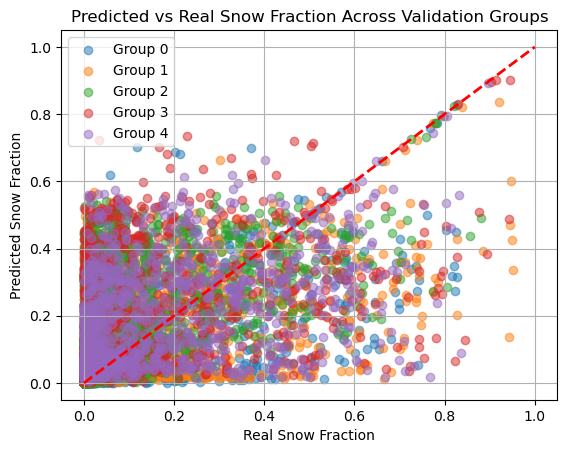

In [3]:
# Load the dataset
sodankyla_topography = xr.open_dataset('sodankyla_topography.nc')
print("Dataset loaded.")

# Define reference pixels using coordinates
grid_shape = sodankyla_topography['snow'].shape
y_coords = sodankyla_topography['y'].values
x_coords = sodankyla_topography['x'].values

# Select 100 stratified reference pixels
reference_coords = stratified_spatial_snow_selection(sodankyla_topography, num_bins=4, num_samples_per_bin=25)

# Create DataFrame for reference pixels
reference_df = pd.DataFrame(reference_coords, columns=['y', 'x'])
reference_df['snow'] = [sodankyla_topography.snow.sel(y=y, x=x, method='nearest').values for y, x in reference_coords]

# Split reference pixels into stratified training and test sets
train_refs, test_refs = split_reference_pixels(reference_df, test_size=0.2, num_bins=4)

# Convert the dataset to a DataFrame based on the split references
df = convert_to_dataframe(sodankyla_topography, train_refs, test_refs)

###

kf = KFold(n_splits=5, shuffle=True, random_state=42)
reference_df['group'] = -1  # Initialize group column

for group_id, (_, test_index) in enumerate(kf.split(reference_df)):
    reference_df.loc[test_index, 'group'] = group_id

# Assign the other training pixels to the same group as their nearest reference pixel
df['group'] = df.apply(
    lambda row: find_nearest_reference((row['y'], row['x']), 
                                       reference_df[reference_df['group'] != -1][['y', 'x']].values), 
    axis=1
).apply(lambda nearest: reference_df[(reference_df['y'] == nearest[0]) & (reference_df['x'] == nearest[1])]['group'].values[0])

print("Group assignment completed.")

###

# Initialize storage for predictions and actual targets for visualization
all_predictions = []
all_targets = []

# Perform 5-fold cross-validation by cycling through each group
for group_id in range(5):
    # Extract features for training and validation based on group
    train_features, train_targets, valid_features, valid_targets = extract_features_from_df(
        df, train_refs, set_type='train', validation_group=group_id, cross_val=True
    )
    
    # Train model on training data for this fold
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_features, train_targets)
    
    # Predict on validation data
    valid_predictions = model.predict(valid_features)
    all_predictions.extend(valid_predictions)
    all_targets.extend(valid_targets)

    # Plot predicted vs. actual for this group
    plt.scatter(valid_targets, valid_predictions, alpha=0.5, label=f'Group {group_id}')

# Final plot configuration for cross-validation results
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
plt.xlabel("Real Snow Fraction")
plt.ylabel("Predicted Snow Fraction")
plt.title("Predicted vs Real Snow Fraction Across Validation Groups")
plt.legend()
plt.grid(True)
plt.show()

Dataset loaded.
Total selected references: 100
100
Splitting reference pixels into stratified training and test sets...
4
Training reference pixels: 75, Test reference pixels: 19
Converting dataset to a DataFrame...


C:\Users\s1803229\AppData\Local\miniforge-pypy3\envs\snow_env_2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\s1803229\AppData\Local\miniforge-pypy3\envs\snow_env_2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\s1803229\AppData\Local\miniforge-pypy3\envs\snow_env_2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


DataFrame created with 10920 entries.
Extracting features for train set...
Features and targets extracted for train set: 9194 samples.
Extracting features for test set...
Features and targets extracted for test set: 1726 samples.
Training the neural network...
Neural network training complete.
Evaluating the model...
Training RMSE: 0.12893682987132074


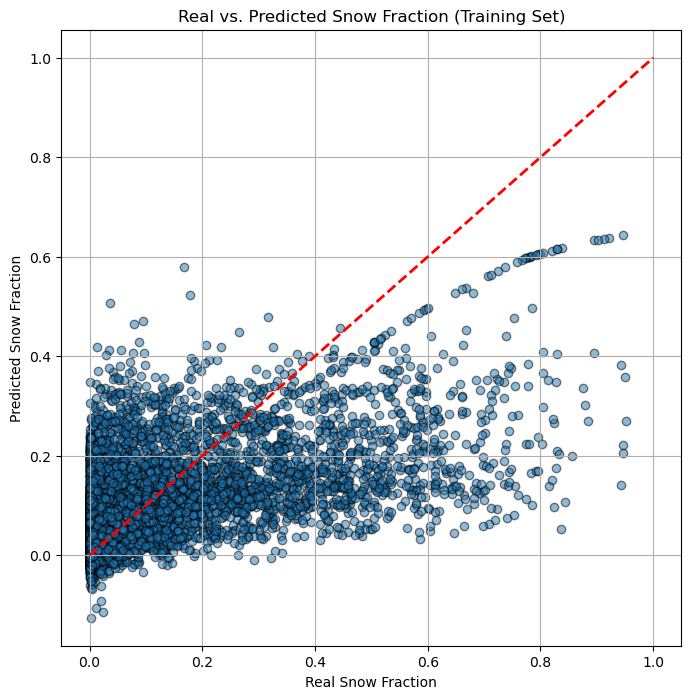

In [14]:
sodankyla_topography = xr.open_dataset('sodankyla_topography.nc')
print("Dataset loaded.")

# Define reference pixels using coordinates
grid_shape = sodankyla_topography['snow'].shape
y_coords = sodankyla_topography['y'].values
x_coords = sodankyla_topography['x'].values

# Select 100 stratified reference pixels
reference_coords = stratified_spatial_snow_selection(sodankyla_topography, num_bins=4, num_samples_per_bin=25)
# reference_coords = create_reference_pixels(grid_shape, y_coords, x_coords)

reference_df = pd.DataFrame(reference_coords, columns=['y', 'x'])
reference_df['snow'] = [sodankyla_topography.snow.sel(y=y, x=x, method='nearest').values for y, x in reference_coords]

# Split reference pixels into stratified training and test sets
train_refs, test_refs = split_reference_pixels(reference_df, test_size=0.2, num_bins=4)

# Convert the dataset to a DataFrame based on the split references
df = convert_to_dataframe(sodankyla_topography, train_refs, test_refs)

# Extract features and targets for training and test sets
train_features, train_targets = extract_features_from_df(df, train_refs, 'train')
test_features, test_targets = extract_features_from_df(df, test_refs, 'test')

#print(train_features, train_targets)

# Train the neural network
print("Training the neural network...")
model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
model.fit(train_features, train_targets)
print("Neural network training complete.")

# Evaluate the model
print("Evaluating the model...")
train_predictions = model.predict(train_features)
#test_predictions = model.predict(test_features)

# Calculate RMSE
train_rmse = root_mean_squared_error(train_targets, train_predictions)
#test_rmse = root_mean_squared_error(test_targets, test_predictions)

print(f"Training RMSE: {train_rmse}")
#print(f"Test RMSE: {test_rmse}")

# Scatter plots for training and test sets
plt.figure(figsize=(8, 8))
plt.scatter(train_targets, train_predictions, alpha=0.5, edgecolors='k', marker='o')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
plt.xlabel('Real Snow Fraction')
plt.ylabel('Predicted Snow Fraction')
plt.title('Real vs. Predicted Snow Fraction (Training Set)')
plt.grid(True)
plt.show()

#plt.figure(figsize=(8, 8))
#plt.scatter(test_targets, test_predictions, alpha=0.5, edgecolors='k', marker='o')
#plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
#plt.xlabel('Real Snow Fraction')
#plt.ylabel('Predicted Snow Fraction')
#plt.title('Real vs. Predicted Snow Fraction (Test Set)')
#plt.grid(True)
#plt.show()

# Description of reference pixels and train/test

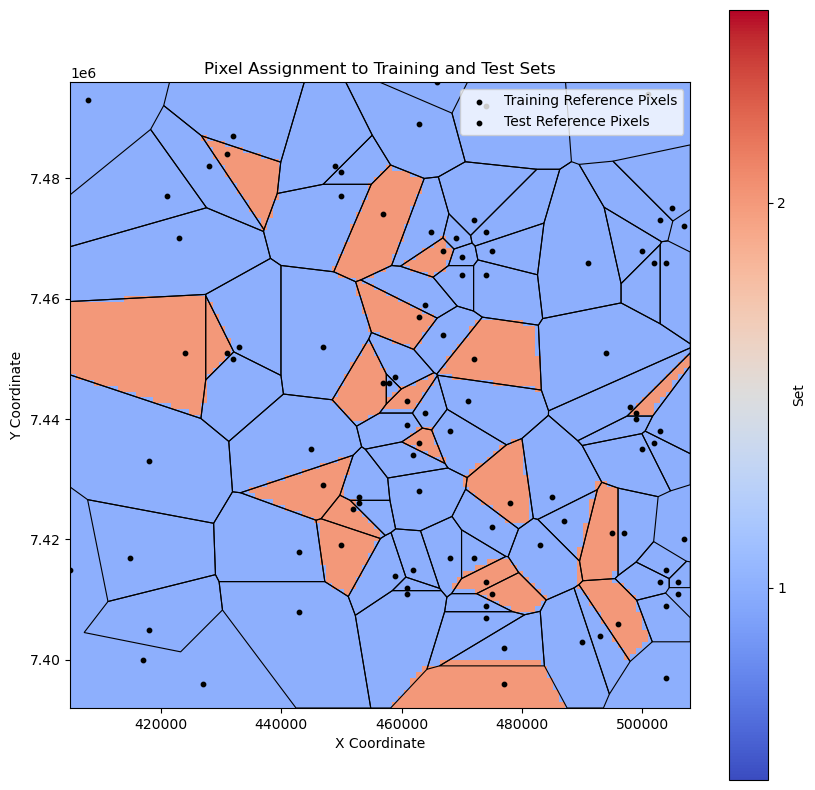

In [5]:
from scipy.spatial import KDTree, Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, LineString
from matplotlib.patches import Polygon as MplPolygon

def assign_pixels_to_sets(dataset, train_refs, test_refs):
    """
    Assign each pixel in the dataset to the training or test set based on the nearest reference pixel.

    Parameters:
    dataset (xr.Dataset): The xarray dataset with 'y' and 'x' coordinates.
    train_refs (list of tuples): List of (y, x) coordinates for training pixels.
    test_refs (list of tuples): List of (y, x) coordinates for test pixels.

    Returns:
    np.ndarray: A 2D mask array with 1 for training pixels and 2 for test pixels.
    """
    # Get all pixel coordinates from the dataset
    y_coords = dataset['y'].values
    x_coords = dataset['x'].values
    pixel_coords = np.array([(y, x) for y in y_coords for x in x_coords])

    # Build KDTree for fast nearest neighbor lookup
    all_refs = np.array(train_refs + test_refs)
    ref_labels = np.array([1] * len(train_refs) + [2] * len(test_refs))  # 1 for train, 2 for test
    tree = KDTree(all_refs)

    # Assign each pixel to the nearest reference pixel's set
    _, nearest_indices = tree.query(pixel_coords)
    pixel_labels = ref_labels[nearest_indices]

    # Reshape to match the dataset grid
    assignment_mask = pixel_labels.reshape(len(y_coords), len(x_coords))

    return assignment_mask

assignment_mask = assign_pixels_to_sets(sodankyla_topography, train_refs, test_refs)

all_refs = np.array([(x, y) for y, x in train_refs + test_refs])
vor = Voronoi(all_refs)

x_min, x_max = sodankyla_topography['x'].values.min(), sodankyla_topography['x'].values.max()
y_min, y_max = sodankyla_topography['y'].values.min(), sodankyla_topography['y'].values.max()

plt.figure(figsize=(10, 10))
plt.imshow(assignment_mask, cmap='coolwarm', origin='upper', extent=[x_min, x_max, y_min, y_max])

plt.colorbar(ticks=[1, 2], label='Set')
plt.clim(0.5, 2.5)  # Ensure color limits match
plt.title("Pixel Assignment to Training and Test Sets")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

bounding_box = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])
for region_idx in vor.regions:
    if not -1 in region_idx and len(region_idx) > 0:  # Ignore regions with -1 (infinity) vertices
        polygon = [vor.vertices[i] for i in region_idx]
        poly = Polygon(polygon)
        if poly.is_valid:
            clipped_poly = poly.intersection(bounding_box)
            if isinstance(clipped_poly, (Polygon, LineString)):
                mpl_poly = MplPolygon(list(clipped_poly.exterior.coords), edgecolor="black", fill=False, linewidth=0.8)
                plt.gca().add_patch(mpl_poly)

train_x, train_y = zip(*[(x, y) for y, x in train_refs])
test_x, test_y = zip(*[(x, y) for y, x in test_refs])
plt.scatter(train_x, train_y, color='black', s=10, label="Training Reference Pixels")
plt.scatter(test_x, test_y, color='black', s=10, label="Test Reference Pixels")

#plt.gca().invert_yaxis()  # Invert y-axis for geographic orientation, if needed
plt.legend()
plt.show()

In [9]:
all_predictions, all_targets

([np.float64(0.0003040000000000001),
  np.float64(0.00011199999999999996),
  np.float64(0.00021600000000000005),
  np.float64(0.0009960000000000001),
  np.float64(0.003232000000000001),
  np.float64(0.005408000000000003),
  np.float64(0.0010319999999999997),
  np.float64(0.0006560000000000003),
  np.float64(0.0011279999999999994),
  np.float64(0.0021399999999999995),
  np.float64(0.032400000000000005),
  np.float64(0.006903999999999998),
  np.float64(0.008643999999999995),
  np.float64(0.002139999999999998),
  np.float64(0.007255999999999999),
  np.float64(0.008152000000000008),
  np.float64(0.004460000000000002),
  np.float64(0.0014359999999999998),
  np.float64(0.001752000000000001),
  np.float64(0.01195200000000001),
  np.float64(0.02570799999999997),
  np.float64(0.0006399999999999997),
  np.float64(0.00035999999999999997),
  np.float64(0.00042800000000000005),
  np.float64(0.0010400000000000003),
  np.float64(0.0013000000000000004),
  np.float64(0.0011320000000000004),
  np.float6

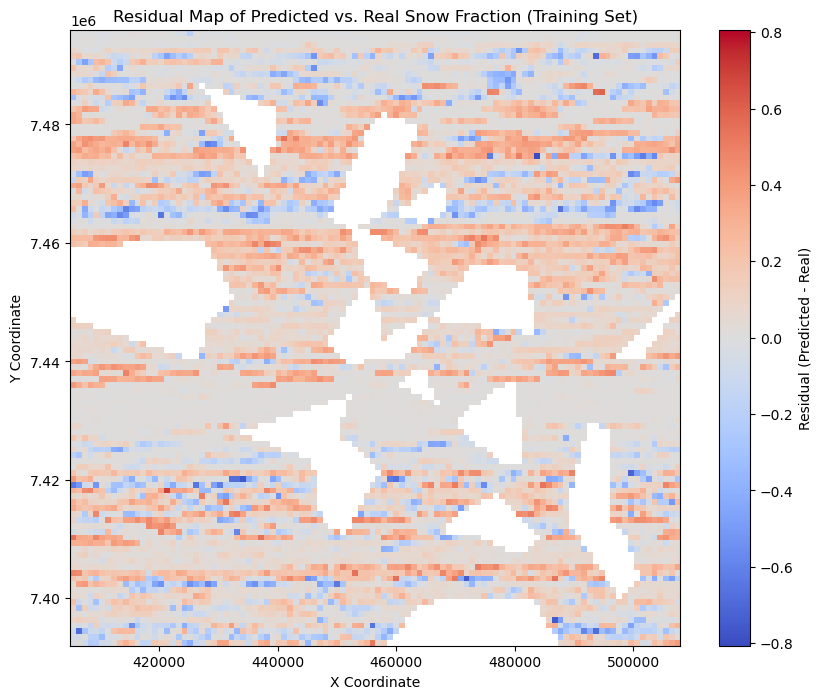

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals for training set
train_residuals = np.array(all_predictions) - np.array(all_targets)

# Create a DataFrame to hold the residuals with their coordinates
train_coords_df = pd.DataFrame({
    'y': df[df['set'] == 'train']['y'].values,
    'x': df[df['set'] == 'train']['x'].values,
    'residual': train_residuals
})

# Pivot the data to create a 2D grid of residuals
residual_map = train_coords_df.pivot(index='y', columns='x', values='residual')

# Determine the color limits to center at 0
vmax = max(abs(train_residuals.min()), abs(train_residuals.max()))

# Plot the residuals on the map
plt.figure(figsize=(10, 8))
plt.imshow(residual_map, cmap='coolwarm', origin='lower', extent=[
    sodankyla_topography['x'].values.min(), sodankyla_topography['x'].values.max(),
    sodankyla_topography['y'].values.min(), sodankyla_topography['y'].values.max()
], vmin=-vmax, vmax=vmax)
plt.colorbar(label='Residual (Predicted - Real)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Residual Map of Predicted vs. Real Snow Fraction (Training Set)')
plt.grid(False)
plt.show()

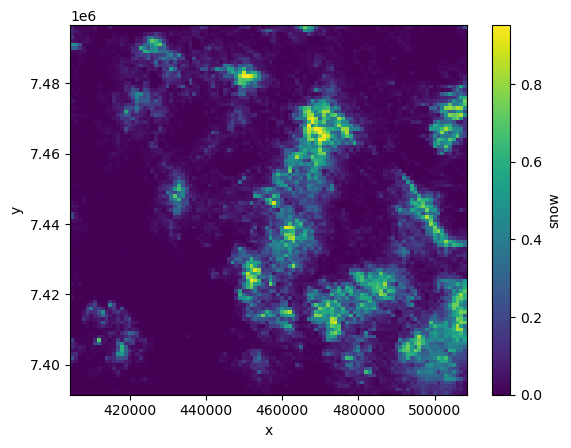

In [41]:
sodankyla_topography.snow.plot()

In [32]:
df

y         x    snow         dem     slope    aspect    set
0      7496000.0  404960.0  0.0860  211.461044  0.092102  4.233273  train
1      7496000.0  405960.0  0.0212  211.369476  0.496697  4.329571  train
2      7496000.0  406960.0  0.0224  194.892059  0.130066  4.574153  train
3      7496000.0  407960.0  0.0088  192.391388  0.174662  3.849383  train
4      7496000.0  408960.0  0.0128  186.968185  0.271040  4.014827  train
...          ...       ...     ...         ...       ...       ...    ...
10915  7392000.0  503960.0  0.1256  218.724182  0.513676  3.000411  train
10916  7392000.0  504960.0  0.0492  221.463425  0.565677  3.065415  train
10917  7392000.0  505960.0  0.0512  207.931000  0.566801  4.330369  train
10918  7392000.0  506960.0  0.0388  185.454666  0.308726  2.962308  train
10919  7392000.0  507960.0  0.0160  181.642700  0.218253  3.010237  train

[10920 rows x 7 columns]

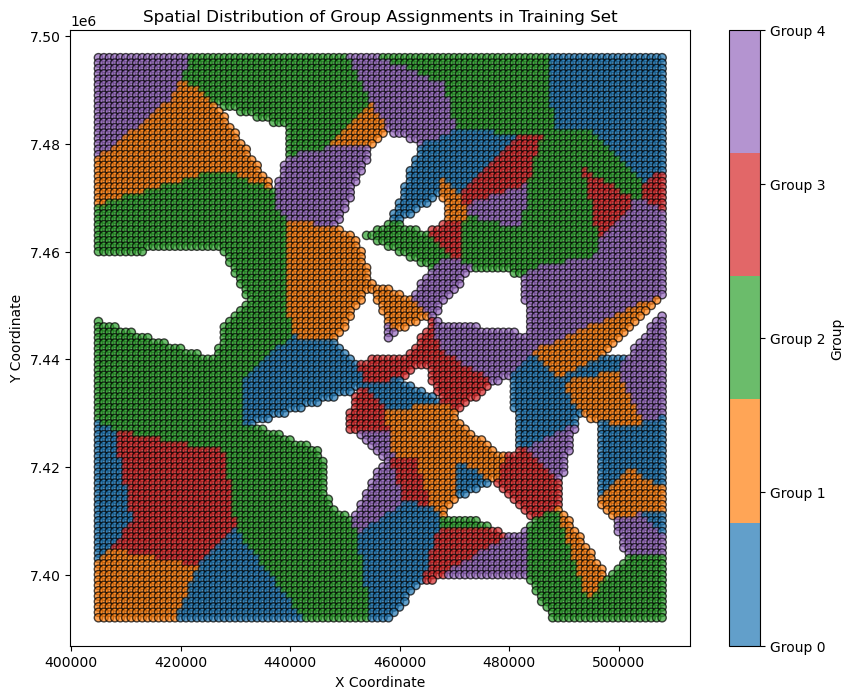

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Limit the color map to the first 5 colors of 'tab10'
cmap = ListedColormap(plt.get_cmap('tab10').colors[:5])

train_coords = df[df['set'] == 'train'][['y', 'x', 'group']]

# Plot the group assignments on a map
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    train_coords['x'], 
    train_coords['y'], 
    c=train_coords['group'], 
    cmap=cmap,  # Use the limited color map
    marker='o', 
    edgecolor='k', 
    alpha=0.7
)

# Adding color bar to show which color corresponds to which group
cbar = plt.colorbar(scatter, ticks=np.arange(5))
cbar.set_label("Group")
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels([f"Group {i}" for i in range(5)])

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Distribution of Group Assignments in Training Set")
plt.grid(False)
plt.show()


(array([10.,  3.,  3.,  6.,  7.,  8.,  8.,  5., 16.,  4.]),
 array([0.     , 0.09456, 0.18912, 0.28368, 0.37824, 0.4728 , 0.56736,
        0.66192, 0.75648, 0.85104, 0.9456 ]),
 <BarContainer object of 10 artists>)

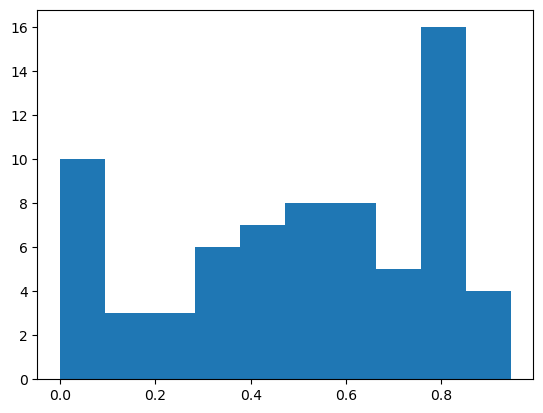

In [49]:
data=[]
for i in range(len(train_refs)):
    data.append(sodankyla_topography.snow.sel(y=train_refs[i][0], x=train_refs[i][1], method='nearest').values)
plt.hist(data)